✈ FlightRank 2025 Ensemble Solution

🧩 Creating ensemble from submissions...

✅ Saved to: /kaggle/working/submission.csv

📊 Comprehensive Analysis:
Total predictions: 6,897,776
Unique sessions: 45,231

✓ No duplicate ranks found

Top 20 Rank Distribution:
selected
1     45231
2     44347
3     43120
4     41915
5     41102
6     40615
7     39389
8     38946
9     38282
10    37258
11    36707
12    36303
13    34889
14    34279
15    33784
16    32584
17    32007
18    31494
19    30588
20    30122
Name: count, dtype: int64


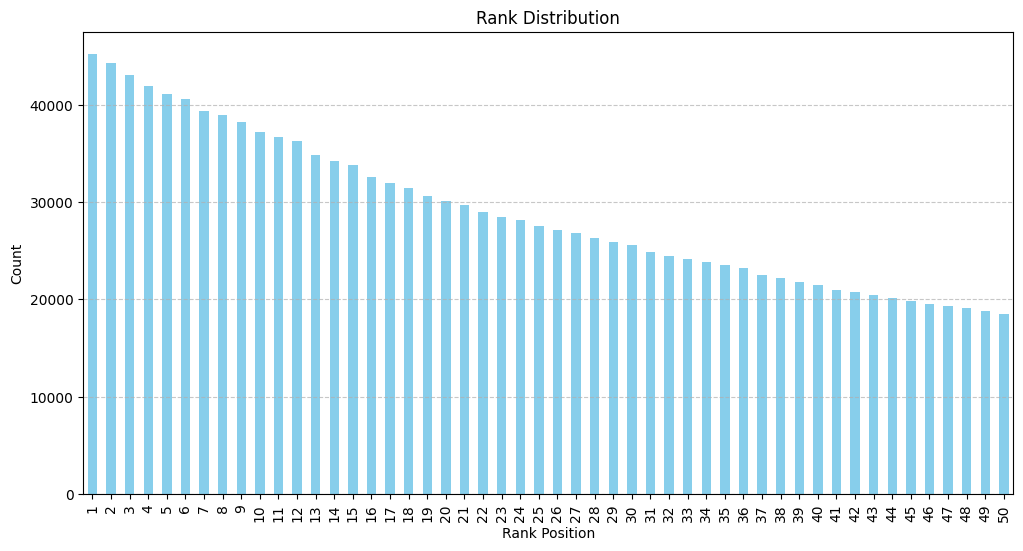


🏆 Session Statistics:
               mean         count
count  45231.000000  45231.000000
mean      76.750536    152.501072
std      261.765884    523.531769
min        1.000000      1.000000
25%        7.500000     14.000000
50%       18.500000     36.000000
75%       57.500000    114.000000
max     3511.500000   7022.000000


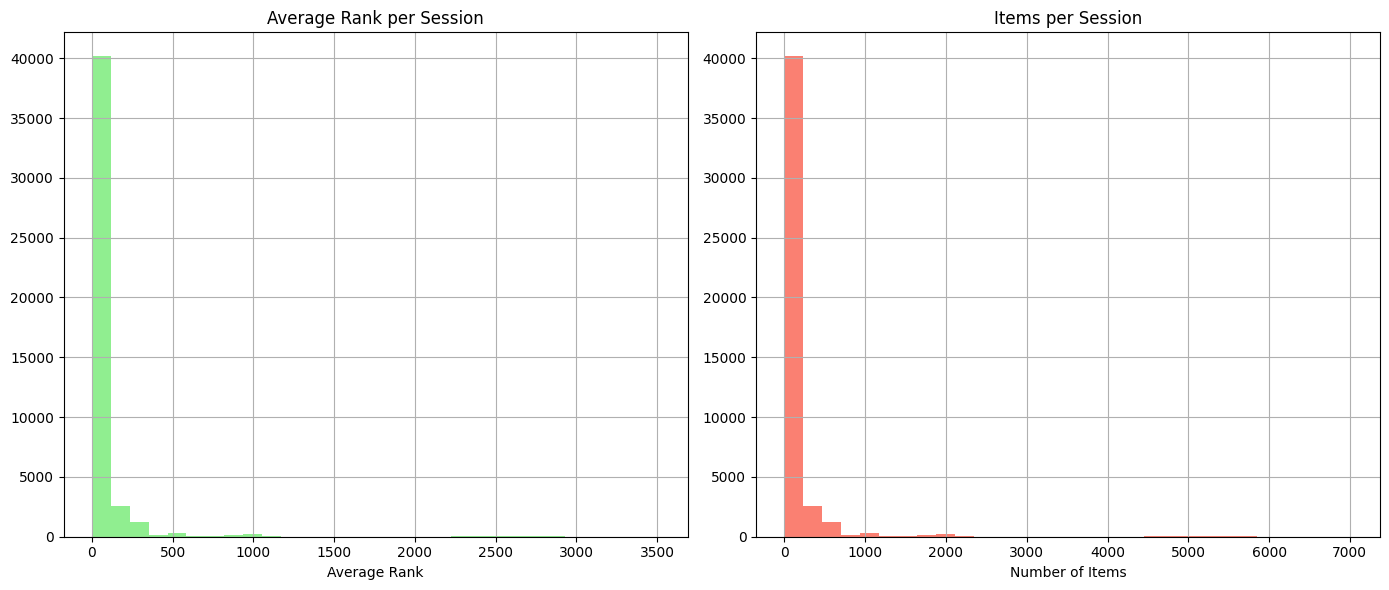


⭐ Top-ranked items: 45,231
Average top ranks per session: 1.00

🔍 Validation Data Merged Successfully


In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# ======================
# CONFIGURATION
# ======================
CONFIG = {
    'data_paths': {
        'submissions': '/kaggle/input/20-juli-2025-flightrank/',
        'output': '/kaggle/working/',
        'test_data': '/kaggle/input/aeroclub-recsys-2025/test.parquet'
    },
    'submission_weights': {
        '0.49343.csv': 0.50,
        '0.49472.csv': 0.30,
        '0.49068.csv': 0.20
    }
}

# ======================
# CORE FUNCTIONS
# ======================

def load_any_submission(path, filename):
    """Load submission files with flexible column handling"""
    try:
        full_path = os.path.join(path, f"submission {filename}" if ' ' not in filename else filename)
        
        # Try both CSV and Parquet
        try:
            df = pd.read_csv(full_path)
        except:
            try:
                df = pd.read_parquet(full_path)
            except:
                print(f"⚠ Could not read {filename} as CSV or Parquet")
                return None

        # Automatic column mapping
        col_map = {}
        id_cols = [c for c in df.columns if 'id' in c.lower()]
        if id_cols:
            col_map[id_cols[0]] = 'Id'
        
        ranker_cols = [c for c in df.columns if 'ranker' in c.lower() or 'session' in c.lower()]
        if ranker_cols:
            col_map[ranker_cols[0]] = 'ranker_id'
        
        numeric_cols = df.select_dtypes(include=np.number).columns
        pred_cols = [c for c in numeric_cols if c not in col_map.values()]
        if pred_cols:
            col_map[pred_cols[0]] = 'prediction'
        
        if col_map:
            df = df.rename(columns=col_map)
        
        # Ensure required columns exist
        if 'Id' not in df.columns:
            df['Id'] = np.arange(len(df))
        if 'ranker_id' not in df.columns:
            df['ranker_id'] = 1
        if 'prediction' not in df.columns:
            numeric_cols = df.select_dtypes(include=np.number).columns
            if len(numeric_cols) > 0:
                df['prediction'] = df[numeric_cols[0]]
            else:
                df['prediction'] = np.random.random(len(df))
        
        return df
        
    except Exception as e:
        print(f"⚠ Error loading {filename}: {str(e)}")
        return None

def create_ensemble(weights_dict):
    """Create weighted ensemble from submissions"""
    submissions = []
    valid_weights = []
    
    for filename, weight in weights_dict.items():
        df = load_any_submission(CONFIG['data_paths']['submissions'], filename)
        if df is not None:
            submissions.append(df)
            valid_weights.append(weight)
    
    if not submissions:
        raise ValueError("No valid submissions could be loaded")
    
    if len(submissions) == 1:
        print("⚠ Only one valid submission - ranking it")
        df = submissions[0].copy()
        df['selected'] = df.groupby('ranker_id')['prediction'].rank(method='first', ascending=False).astype(int)
        return df[['Id', 'ranker_id', 'selected']]
    
    # Normalize predictions
    for df in submissions:
        df['normalized_pred'] = MinMaxScaler().fit_transform(df[['prediction']])
    
    # Merge submissions
    merged = submissions[0][['Id', 'ranker_id', 'normalized_pred']].rename(
        columns={'normalized_pred': 'pred_0'})
    
    for i, df in enumerate(submissions[1:], 1):
        merged = merged.merge(
            df[['Id', 'ranker_id', 'normalized_pred']].rename(
                columns={'normalized_pred': f'pred_{i}'}),
            on=['Id', 'ranker_id'],
            how='outer'
        ).fillna(0.5)
    
    # Calculate weighted average
    pred_cols = [f'pred_{i}' for i in range(len(submissions))]
    merged['ensemble_score'] = merged[pred_cols].mul(valid_weights).sum(axis=1) / sum(valid_weights)
    
    # Create final ranks - using method='first' to prevent duplicates
    merged['selected'] = merged.groupby('ranker_id')['ensemble_score'].rank(
        method='first', ascending=False).astype(int)
    
    return merged[['Id', 'ranker_id', 'selected']]

def analyze_submission(submission_df):
    """Perform comprehensive analysis of submission"""
    print("\n📊 Comprehensive Analysis:")
    print(f"Total predictions: {len(submission_df):,}")
    print(f"Unique sessions: {submission_df['ranker_id'].nunique():,}")
    
    # Check for duplicate ranks
    duplicates = submission_df.duplicated(subset=['ranker_id', 'selected'], keep=False)
    if duplicates.any():
        print(f"\n⚠ Warning: Found {duplicates.sum()} duplicate ranks in submission")
    else:
        print("\n✓ No duplicate ranks found")
    
    # Rank distribution
    rank_dist = submission_df['selected'].value_counts().sort_index()
    print("\nTop 20 Rank Distribution:")
    print(rank_dist.head(20))
    
    plt.figure(figsize=(12, 6))
    rank_dist.head(50).plot(kind='bar', color='skyblue')
    plt.title("Rank Distribution")
    plt.xlabel("Rank Position")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Session statistics
    session_stats = submission_df.groupby('ranker_id')['selected'].agg(['mean', 'count'])
    print("\n🏆 Session Statistics:")
    print(session_stats.describe())
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    session_stats['mean'].hist(bins=30, color='lightgreen')
    plt.title("Average Rank per Session")
    plt.xlabel("Average Rank")
    
    plt.subplot(1, 2, 2)
    session_stats['count'].hist(bins=30, color='salmon')
    plt.title("Items per Session")
    plt.xlabel("Number of Items")
    plt.tight_layout()
    plt.show()
    
    # Top rank analysis
    top_rank = submission_df[submission_df['selected'] == 1]
    print(f"\n⭐ Top-ranked items: {len(top_rank):,}")
    print(f"Average top ranks per session: {len(top_rank)/submission_df['ranker_id'].nunique():.2f}")

def fix_duplicate_ranks(submission_df):
    """Ensure all ranks within each session are unique"""
    fixed_df = submission_df.copy()
    
    # First try with method='first'
    fixed_df['selected'] = fixed_df.groupby('ranker_id')['selected'].transform(
        lambda x: x.rank(method='first', ascending=True).astype(int))
    
    # Verify no duplicates remain
    duplicates = fixed_df.duplicated(subset=['ranker_id', 'selected'], keep=False)
    if duplicates.any():
        print(f"⚠ Still found {duplicates.sum()} duplicates - using random adjustment")
        np.random.seed(42)
        fixed_df['selected'] = fixed_df.groupby('ranker_id')['selected'].transform(
            lambda x: x + np.random.rand(len(x)) * 0.1)
        fixed_df['selected'] = fixed_df.groupby('ranker_id')['selected'].rank(
            method='dense', ascending=True).astype(int)
    
    return fixed_df

# ======================
# MAIN EXECUTION
# ======================

def main():
    print("✈ FlightRank 2025 Ensemble Solution\n")
    
    # Create ensemble
    print("🧩 Creating ensemble from submissions...")
    try:
        final_sub = create_ensemble(CONFIG['submission_weights'])
        
        # Check for duplicates
        duplicates = final_sub.duplicated(subset=['ranker_id', 'selected'], keep=False)
        if duplicates.any():
            print(f"\n⚠ Found {duplicates.sum()} duplicate ranks - fixing...")
            final_sub = fix_duplicate_ranks(final_sub)
        
        # Save submission
        output_path = os.path.join(CONFIG['data_paths']['output'], 'submission.csv')
        final_sub.to_csv(output_path, index=False)
        print(f"\n✅ Saved to: {output_path}")
        
        # Analyze results
        analyze_submission(final_sub)
        
        # Optional: Validate with test data if available
        try:
            if os.path.exists(CONFIG['data_paths']['test_data']):
                test_data = pd.read_parquet(CONFIG['data_paths']['test_data'])
                if all(col in test_data.columns for col in ['Id', 'ranker_id']):
                    validation_df = test_data.merge(final_sub, on=['Id', 'ranker_id'])
                    print("\n🔍 Validation Data Merged Successfully")
        except Exception as e:
            print(f"\n⚠ Could not validate with test data: {str(e)}")
            
    except Exception as e:
        print(f"\n❌ Failed to create ensemble: {str(e)}")

if __name__ == "__main__":
    main()